In [2]:
import numpy as np
import numpy.random as rng
import pandas as pd

import scipy
import random
import pymc3 as pm
from datetime import datetime, date, timedelta

import cvxopt as opt
from cvxopt import blas, solvers
import random
import re
import sys
import json
import time
from pathlib import Path

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set(style="ticks", color_codes=True)
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
#import daft

import theano
theano.config.warn.round=False

In [5]:
import h5py
from util import category_to_int

%load_ext autoreload
%autoreload 2


## Goal: predict infant-mortality rate per 1000 live births among different countries
## Step 0: pre-data processing & analysis
> https://www.rdocumentation.org/packages/car/versions/2.1-6/topics/Leinhardt


**Format**
This data frame contains the following columns

**income**
Per-capita income in U. S. dollars.

**infant**
Infant-mortality rate per 1000 live births.

**region**
A factor with levels: Africa; Americas; Asia, Asia and Oceania; Europe.

**oil**
Oil-exporting country. A factor with levels: no, yes.



In [18]:
dta = pd.read_csv(u'data/Leinhardt.csv',sep=',').dropna()
dta.head(3)

Unnamed: 0  income  infant  region oil
0  Australia    3426    26.7    Asia  no
1    Austria    3350    23.7  Europe  no
2    Belgium    3346    17.0  Europe  no

In [19]:


dta.set_index(dta.columns[0], drop = True, inplace = True)
dta.index.rename('index',inplace = True)
dta.head()

## we can keep a copy of original data
dta_original = dta.copy(deep = True)
dta_original.head(3)

income  infant  region oil
index                                
Australia    3426    26.7    Asia  no
Austria      3350    23.7  Europe  no
Belgium      3346    17.0  Europe  no

In [15]:
dta = dta_original

In [20]:
## transform categorical data to ints
label_dicts = category_to_int(dta,['region','oil'],True)
dta.head(3)

region {0: 'Africa', 1: 'Americas', 2: 'Asia', 3: 'Europe'}
oil {0: 'no', 1: 'yes'}


income  infant  region  oil
index                                 
Australia    3426    26.7       2    0
Austria      3350    23.7       3    0
Belgium      3346    17.0       3    0

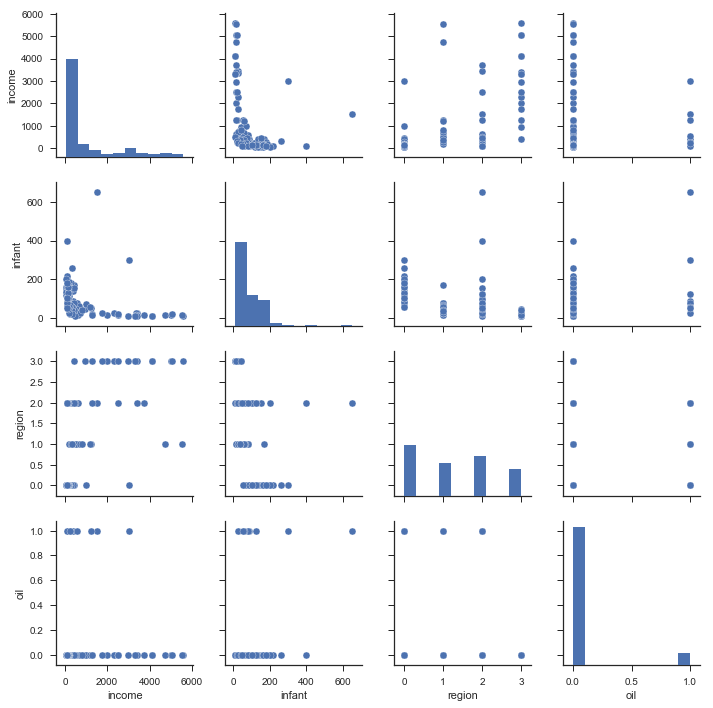

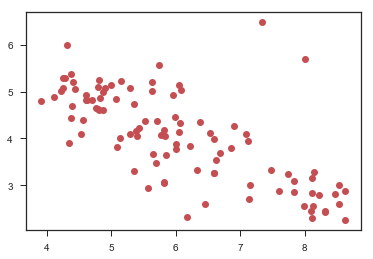

In [21]:
## we can explore other data
sns.pairplot(dta)
plt.show()
x = np.log(dta['income'])
y = np.log(dta['infant'])
plt.plot(x,y,'ro')
plt.show()

In [10]:
dta['infant'] = np.log(dta['infant'])
dta['income'] = np.log(dta['income'])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


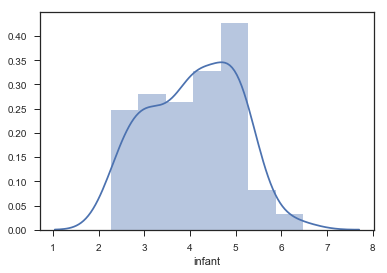

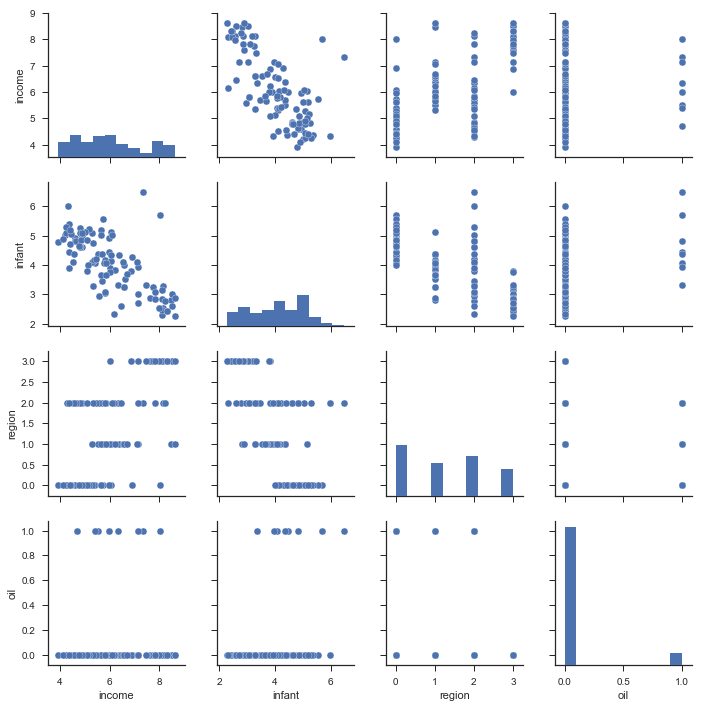

In [11]:
## step 0: explore the data
## sns.distplot gives density curve and histogram
## sns.pairplot gives pairwise data plots
sns.distplot(dta['infant'])
plt.show()
sns.pairplot(dta)
plt.show()

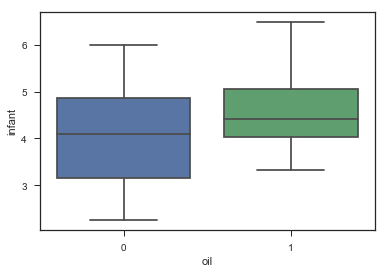

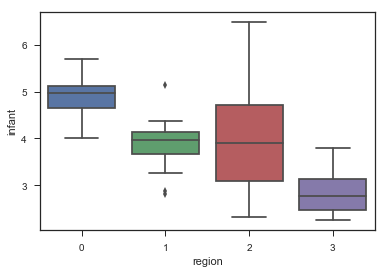

In [12]:
ax = sns.boxplot(x="oil", y="infant", data=dta)
plt.show()
ax = sns.boxplot(x="region", y="infant", data=dta)
plt.show()

## Step1: model selections -- start with the simplest: OLS


In [ ]:
# simpliest linear regression using statsmodels
# minimize y-

import statsmodels.api as sm 
y  = dta['infant'].as_matrix().T
x  = dta['income'].as_matrix().T
X = sm.add_constant(x)
ols_model = sm.OLS(y, X).fit()
predictions = ols_model.predict(X)

print(ols_model.summary())
plt.plot(x,predictions,'ro')
plt.show()

ols_model.params

## step 1: model prep -- linear

1. Naive Linear Model: $$y_i|\tilde{x_i},\beta,\sigma^2 \sim_{ind}       N(\beta_0+\beta_1x_{1_i}+\beta_2x_{2_i}+\beta_3x_{3_i},\sigma^2)$$
where $y_i$ is the $log$ mortality for country $i$, $x_{1_i}$'s are incomes for country $i$,  $x_{2_i}$ corresponds to if a country export oil,   $x_{3_i}$ corresponds to country's region.
   
1. We apply random intercept model. The group of intercepts will come from a common distribution. So, we will modify $\beta_0+\beta_3x_{3_i}$, the intercept, to more parameters -- $r_i$ -- as region
$$y_i|(\alpha,r_i),\tilde{x_i},\beta,\sigma^2 \sim_{ind} N(\alpha_{r_i}+\beta_1x_{1_i}+\beta_2x_{2_i},\sigma^2)$$
where $r_i\in\{0,..,3\}$, $i= 1..n$, $n$ is the number of data

1. Now, we can make further prior assumptions on current parameters
$$\alpha_r~|\mu,\tau^2 \sim_{iid} N(\mu, \tau^2),r\in\{0,..,3\}$$
where,
$$\mu~\sim N(0,10^6)$$

$$\tau^2 ~\sim \frac{1}{\textit{ gamma }(\alpha = .5, \beta = 5)} = IG(\alpha,\frac{1}{\beta})$$

Here $\mu$ correponds to intercepts across all regions, $\tau^2$ corresponds to volatility of the intercepts across regions. 
The relation amount parameters and observed data is:
<img src="data\graph_rep.png" alt="Drawing" style="width: 300px;"/>

In [20]:

## step 1: set up the model

y      = dta['infant'].as_matrix().T # response

region = dta['region'].as_matrix().T
oil    = dta['oil'].as_matrix().T
income = dta['income'].as_matrix().T

param1 = ['a'+str(i) for i in set(region)]
npar1  = len(param1)

param2 = ['b'+str(i) for i in range(2)]
npar2  = len(param2)

param  = param1 +['mua','siga']+ param2 + ['sig']
npar   = len(param)

niter = int(5e3)

with pm.Model() as linreg:
    mua  = pm.Normal('mua',mu = 0, sd = 1e6)
    # inverse gamma; 
    preca = pm.Gamma('preca',alpha = 1/2, beta = 10./2)
    siga = pm.Deterministic('siga',pm.math.sqrt(1./preca)) 
    a = []
    for ai in param1:
        a.append(pm.Normal(ai,mu = mua,sd = siga))
    
    b = []
    for bi in param2:
        b.append(pm.Normal(bi, mu = 0, sd = 1e6))
    
    prec =  pm.Gamma('prec', alpha = 5/2., beta = 50/2.)
    sig =  pm.Deterministic('sig',pm.math.sqrt(1./prec)) 
    ##sig2 = pm.InverseGamma('preca', alpha = 5/2, beta = 5*10/2)
    ##sig  = pm.Deterministic('sig',pm.math.sqrt(sig2)) 
    y_est = []
    
    for i in range(0,len(y)):
        y_est.append(a[region[i]] + b[0]*income[i]+b[1]*oil[i]) 
        
    likelihood = pm.Normal('y',mu = y_est, sd = sig, observed = y)

<img src="data\expofamily.png" alt="Drawing" style="width: 600px;"/>



## step 2: obtain maximize a posteriori (MAP) point to estimate for the parameters
1. find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm -- an approximation of Newton’s method that approximates the Hessian and assumes expands the function as a Taylor expansion) to find the maximum of the log-posterior, 
1.  MAP also allows selection of other optimization algorithms from the scipy.optimize module.z For example, below we use Powell’s method to find the MAP.


In [21]:
time1 = time.time()
map_estimate = pm.find_MAP(model=linreg)
time2 = time.time()
eff   = time2 - time1
print("time = ",  eff)
for par in param:
    print(par,map_estimate[par])



  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -346.71, ||grad|| = 242.2:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -264.19, ||grad|| = 134.37:   0%|          | 10/5000 [00:00<00:08, 605.99it/s]
logp = -200.11, ||grad|| = 11.586:   0%|          | 20/5000 [00:00<00:07, 631.05it/s]
logp = -179.7, ||grad|| = 6.0105:   1%|          | 30/5000 [00:00<00:07, 643.60it/s] 
logp = -178.94, ||grad|| = 4.3535:   1%|          | 40/5000 [00:00<00:07, 647.57it/s]
logp = -199.62, ||grad|| = 177.22:   1%|          | 50/5000 [00:00<00:08, 608.34it/s]
logp = -199.62, ||grad|| = 177.22:   1%|          | 52/5000 [00:00<00:10, 462.47it/s]
logp = -176.45, ||grad|| = 0.15503:   1%|          | 60/5000 [00:00<00:10, 462.47it/s]
logp = -176.45, ||grad|| = 0.15503: 100%|██████████| 67/67 [00:00<00:00, 452.33it/s]  

time =  16.71285104751587
a0 6.567474290580306
a1 6.026237840034903
a2 5.861865564591391
a3 5.55416686476952
mua 6.002446826894411
siga 1.8747099456450376
b0 -0.3436804802002328
b1 0.6439133453813229
sig 0.8942164974847935


In [19]:
## step 2: other optimization method
from scipy import optimize
time1 = time.time()
map_estimate2 = pm.find_MAP(model=linreg, fmin=optimize.fmin_powell)
time2 = time.time()
eff   = time2 - time1
print("time = ",  eff)
for var in param:
    print(var,map_estimate2[var])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -175.97:  15%|█▌        | 750/5000 [00:00<00:03, 1153.87it/s] 

Optimization terminated successfully.
         Current function value: 175.967117
         Iterations: 8
         Function evaluations: 755
time =  22.67621397972107
a0 6.562350703333086
a1 6.019702180328511
a2 5.85587414317132
a3 5.545924182559693
mua 5.995766258727326
siga 1.8744874535884992
b0 -0.3426601285029669
b1 0.6445288509209509
sig 0.8763390087290363


logp = -175.97:  15%|█▌        | 755/5000 [00:20<00:03, 1153.87it/s]

In [22]:
niter = int(5e3)
with linreg:
    start = map_estimate
    stepper = pm.NUTS()
    trace= pm.sample(niter, start = start,random_seed=123,step = stepper)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):

logp = -175.97:  15%|█▌        | 755/5000 [02:20<13:07,  5.39it/s]  
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size du

In [22]:
#pm.traceplot(trace);

## step 3: model checking -- For MC, we need to check if it converges

** observations**: for each parameter, if its histogram of every sample interval look similar, this provide some evidence  that the chain converges.

Note that if a parameter centers around zero, then the parameter is basically == 0, which also means it is irrelavant to the predictor $y$, so we can ** delete those parameters and retrain the model**

a0 6.554523704003199


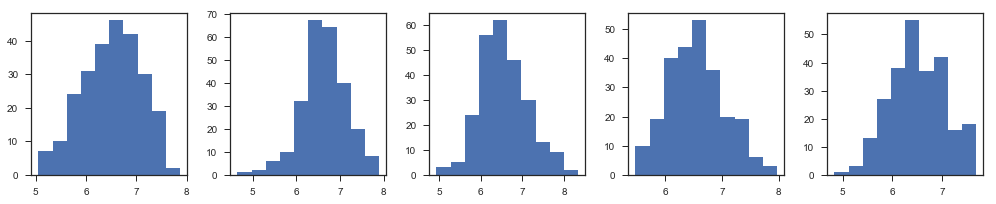

a1 6.014754285227964


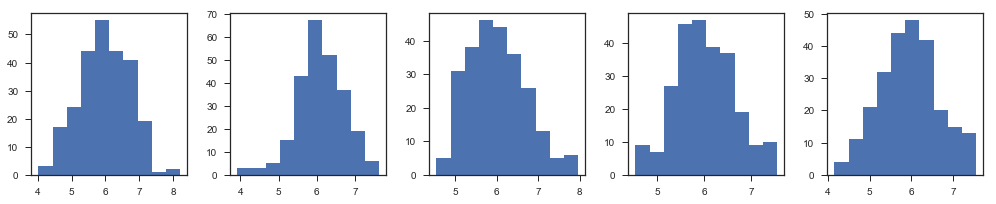

a2 5.84398118907036


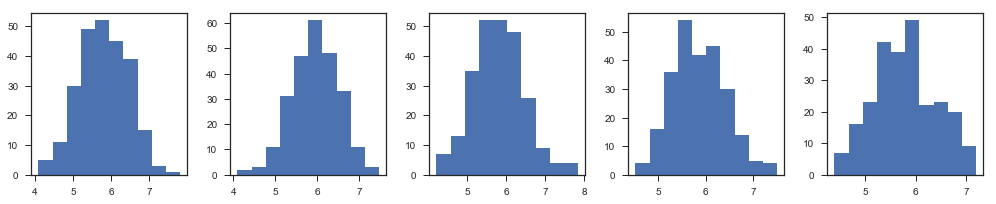

a3 5.542487813051744


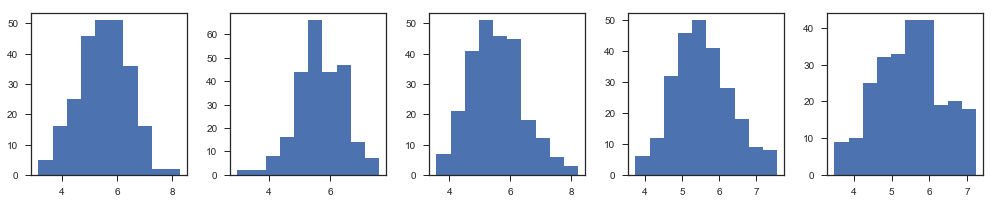

mua 5.927845264739129


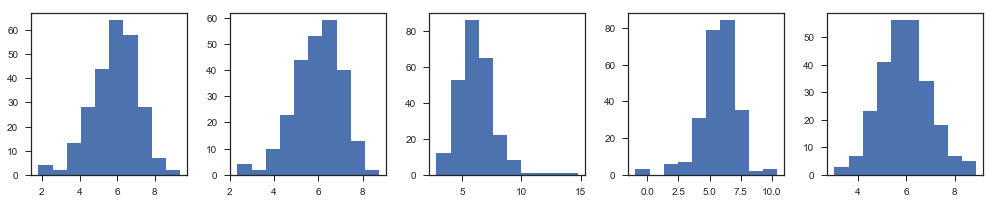

siga 2.072184554627672


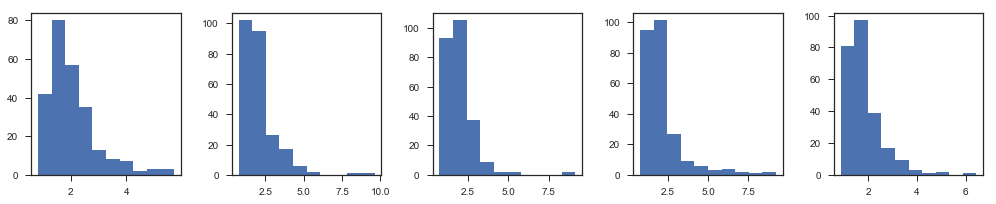

b0 -0.34243768216376635


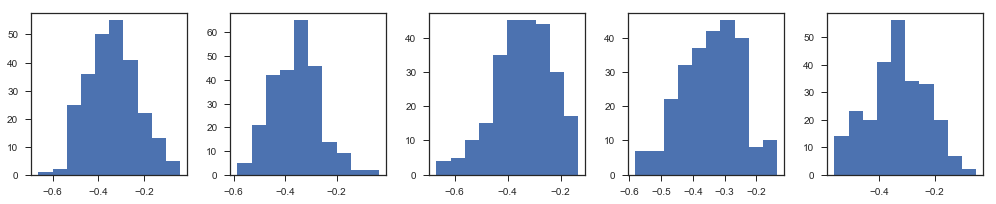

b1 0.6456186179741998


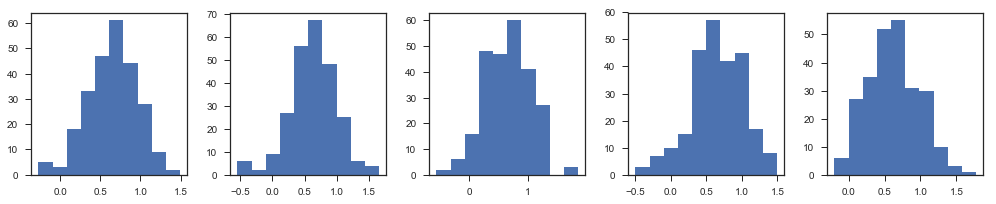

sig 0.9217467764178904


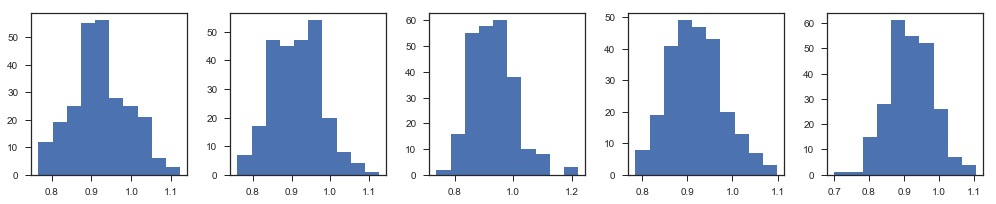

In [23]:
coef_trace1= pd.Series(index = param)

for i in range(0,len(param)):
    var = param[i]
    coef_trace1[var] = trace.get_values(var,burn = niter//2).mean()
    print(var,coef_trace1[var])

    beta_trace = trace[var][niter//2:]
    fig, axes = plt.subplots(1, 5, figsize=(14,3))
    axes = axes.ravel()
    for i in range(5):
        axes[i].hist(beta_trace[250*i:250*(i+1)])
    plt.tight_layout()
    plt.show()

# the summary of parameters in pm


In [22]:
#pm.traceplot(trace);

### step 3: model checking continue
### observations: multiple chain converg; we would expect at least two chains to converge


In [24]:

resmu = pd.Series(np.random.randn(len(param)), index=param)
ressd = resmu.copy(deep = True)

nchain = 3
chain_start = [{par:0 for par in param} for i in range(0,nchain)]

#extract result from our first chain
for var in resmu.index:
    val =  trace.get_values(var)
    resmu[var] = np.mean(val)
    ressd[var] = np.std(val)    
    for i in range(0,nchain):
        chain_start[i][var] = random.uniform(resmu[var]-2*ressd[var],resmu[var]+2*ressd[var])
#get initial values for the rest of the chain
#np.random.uniform(-ressd, ressd)¶


In [25]:
niter = int(5e3)
with linreg:
    start= chain_start
    step = pm.NUTS()
    multi_trace1= pm.sample(niter,njobs = nchain, random_seed=123,stepper = NUTS())    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 5500/5500 [01:58<00:00, 46.40it/s]


a0


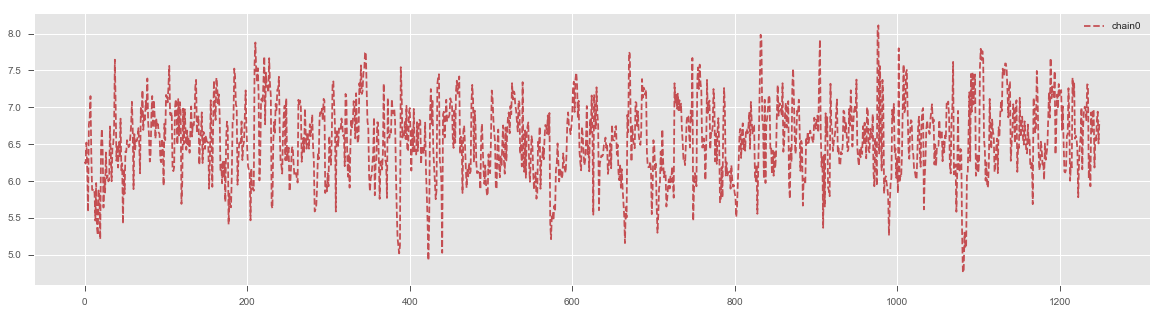

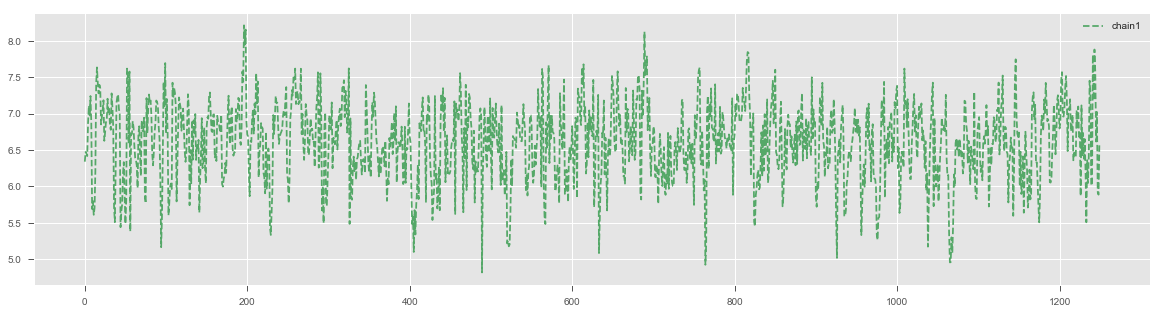

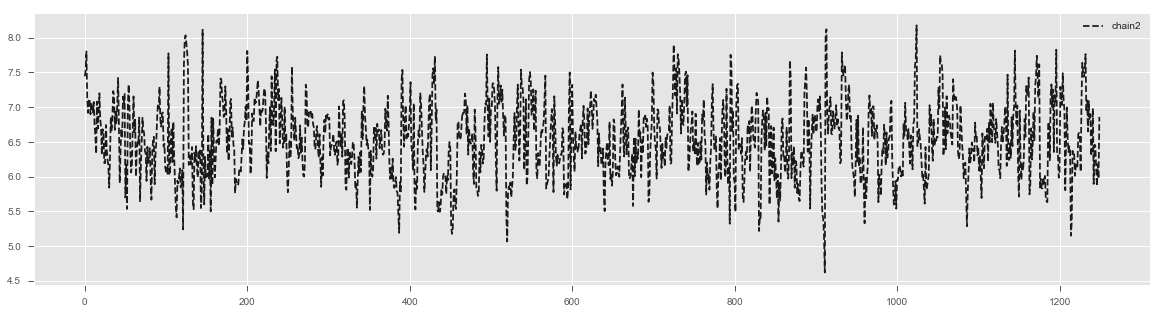

a1


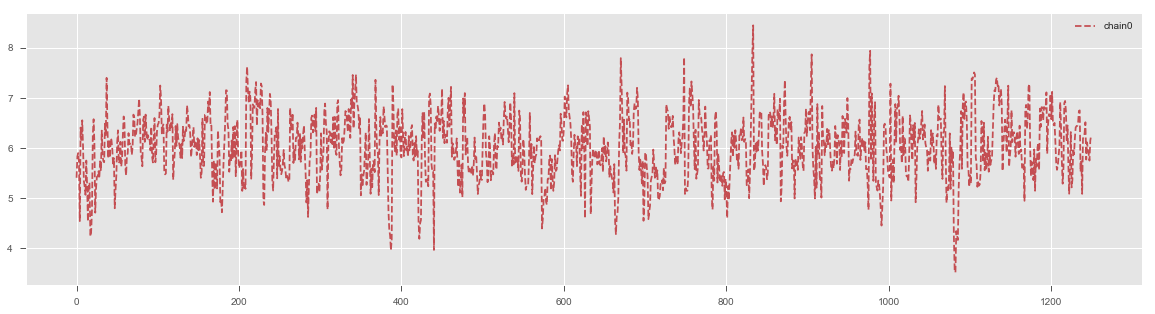

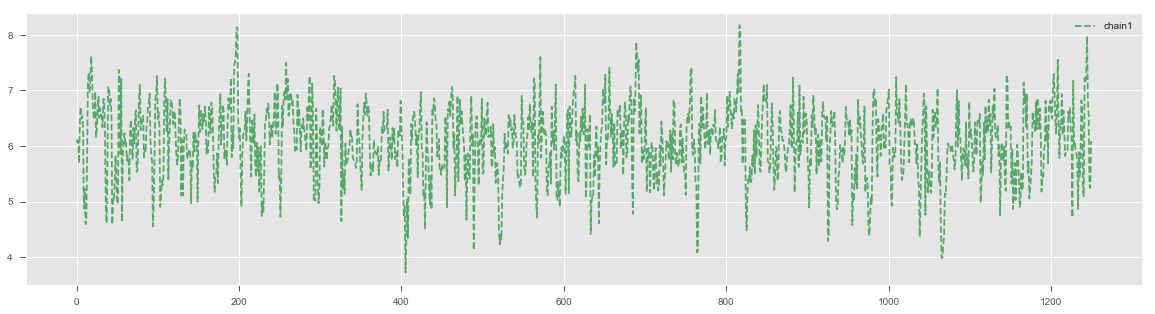

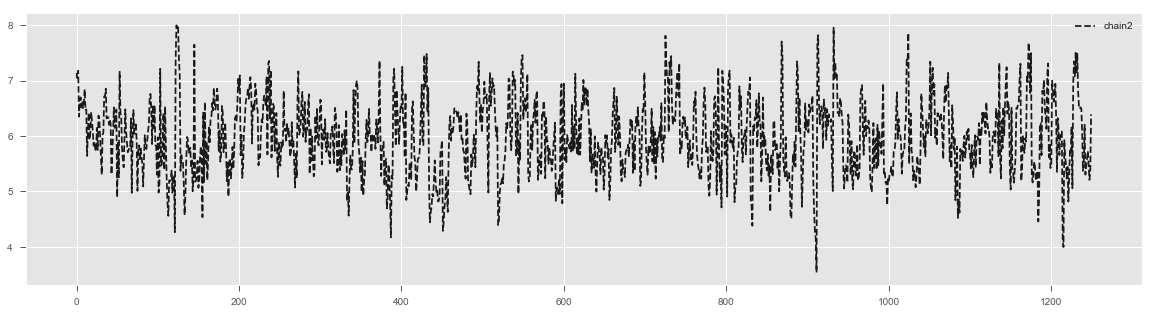

a2


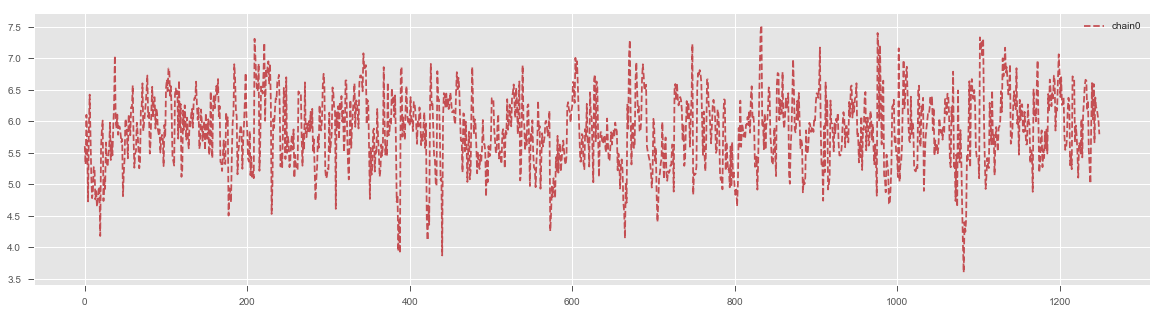

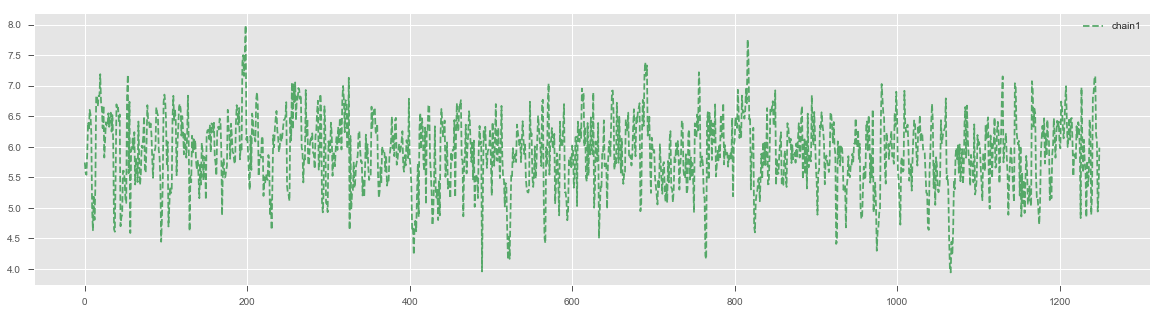

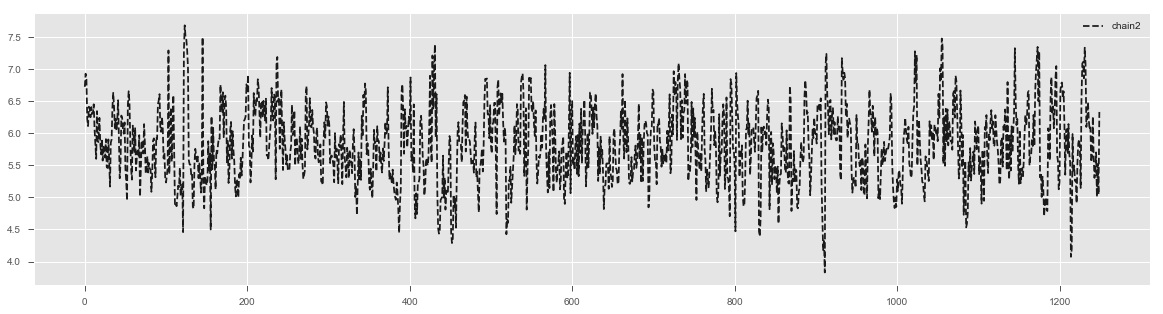

a3


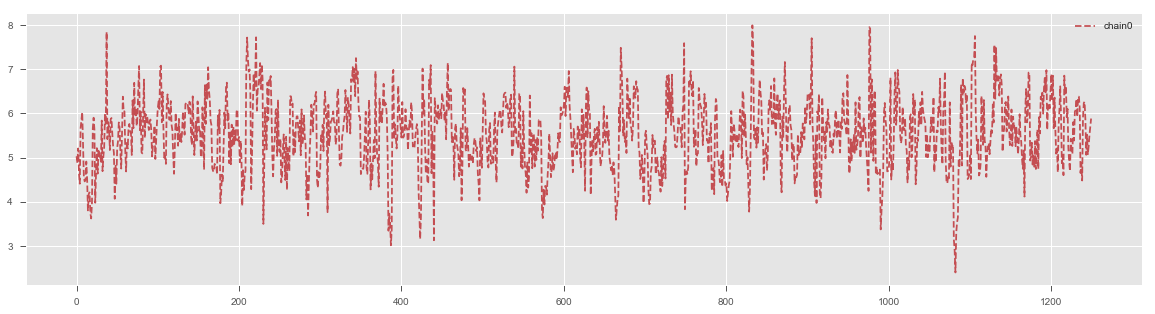

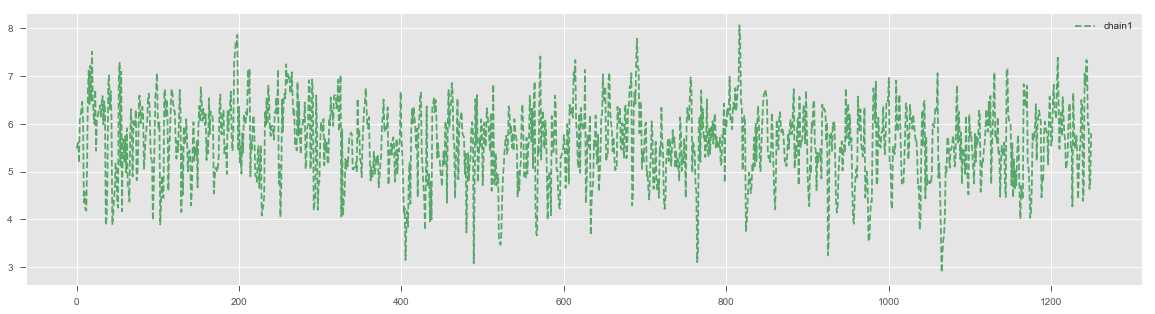

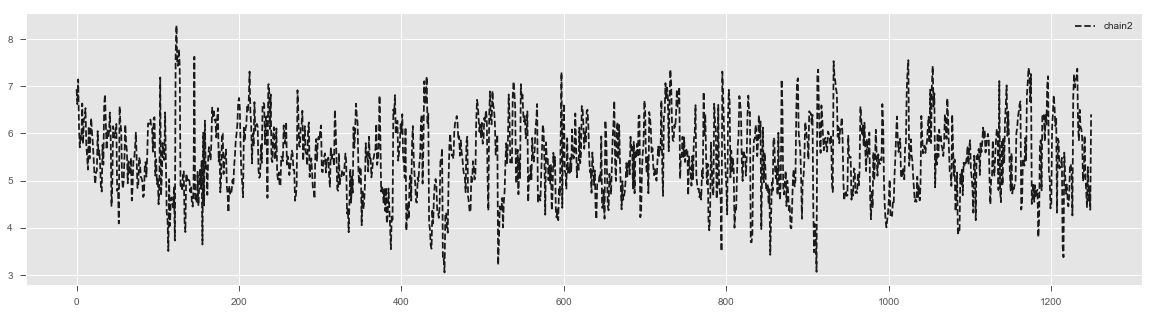

mua


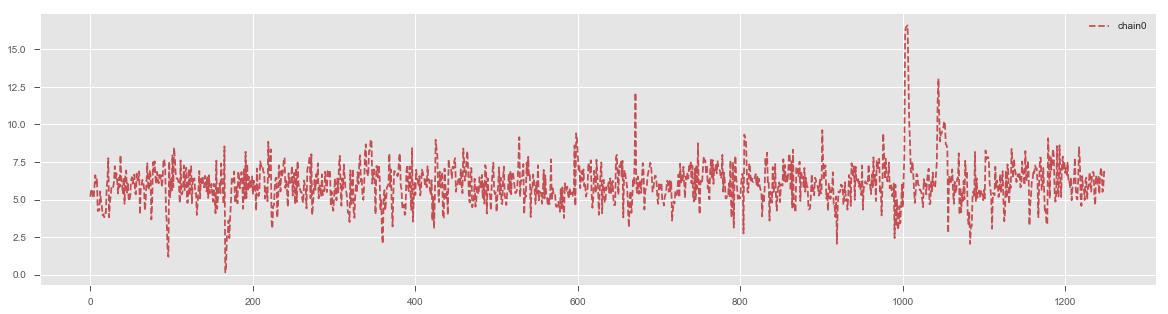

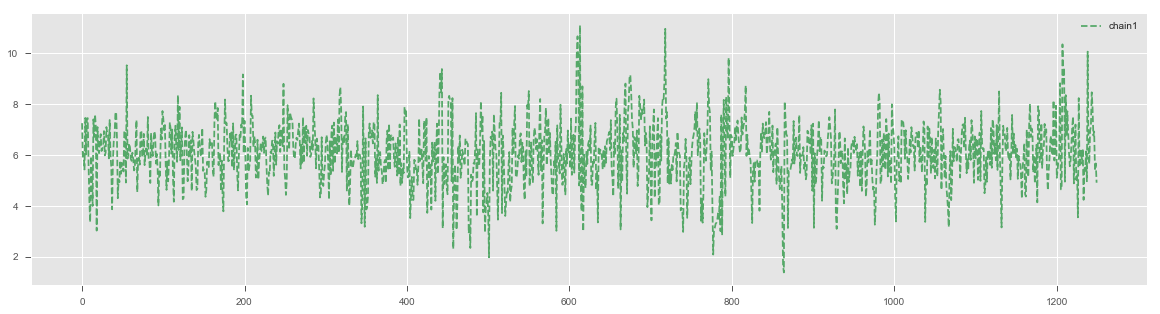

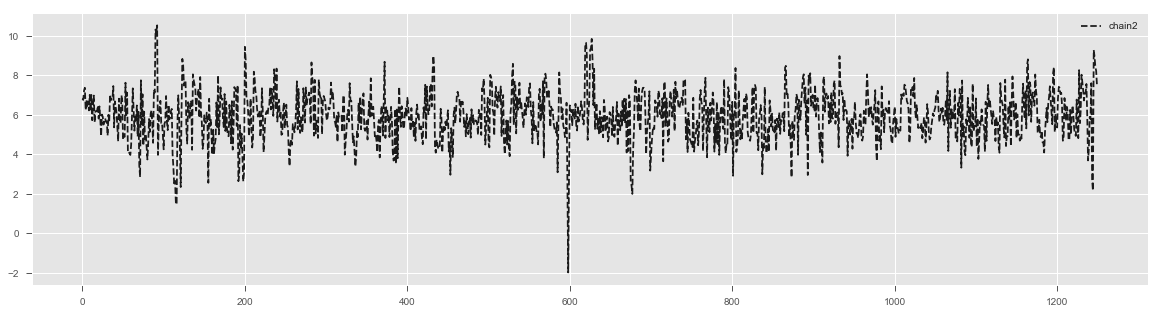

siga


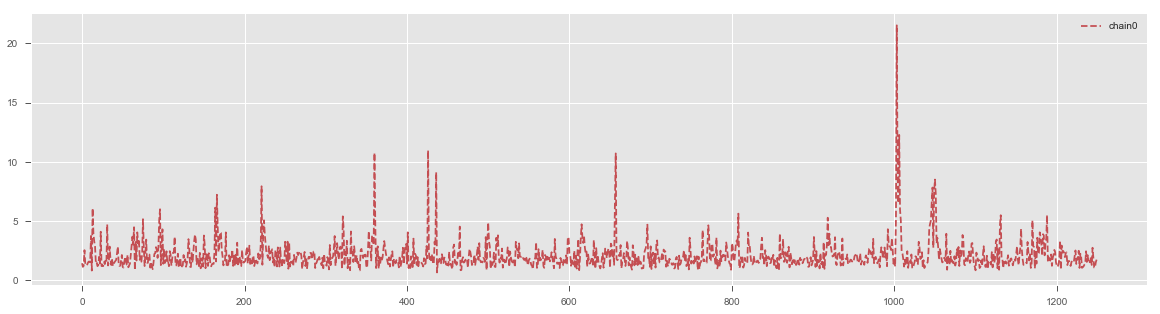

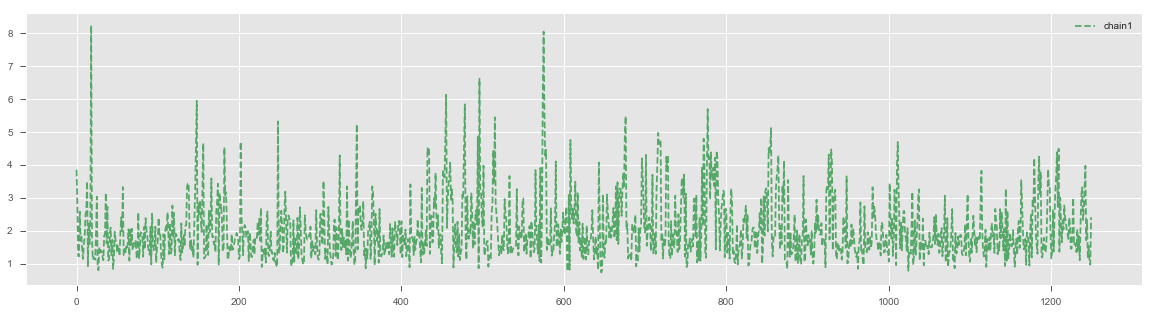

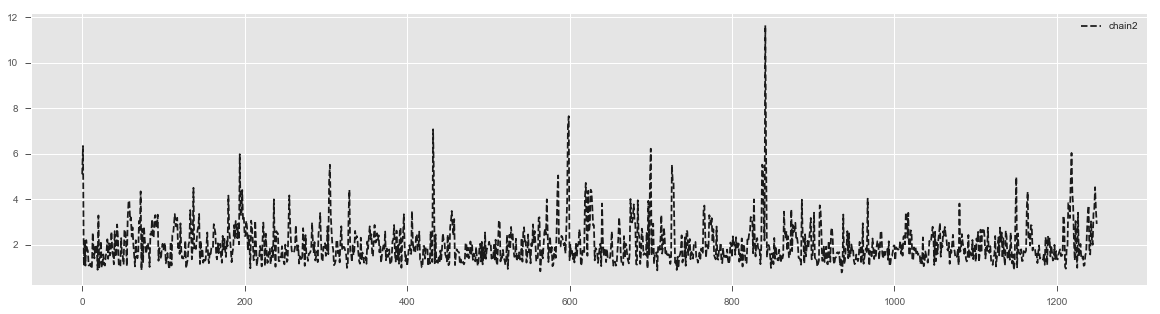

b0


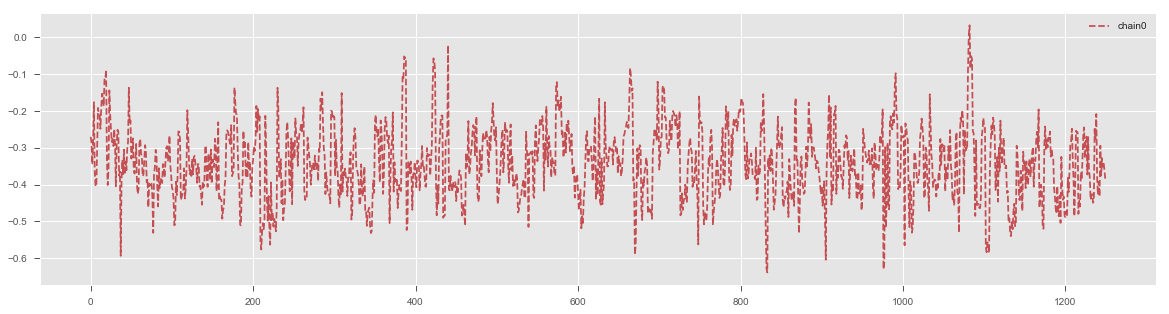

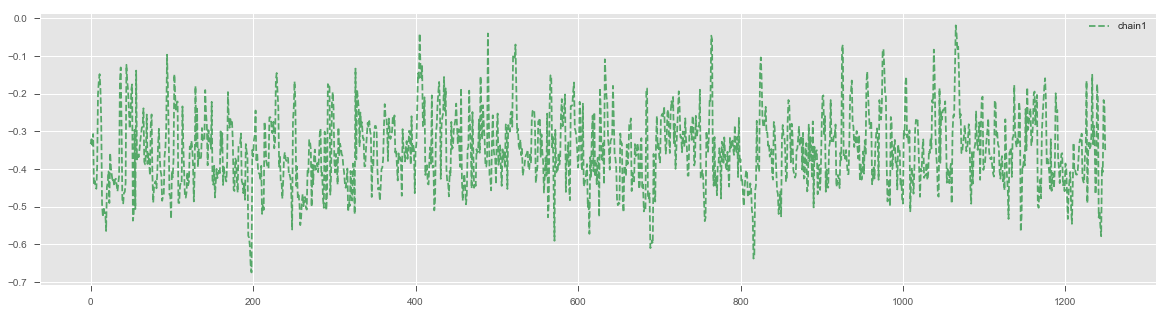

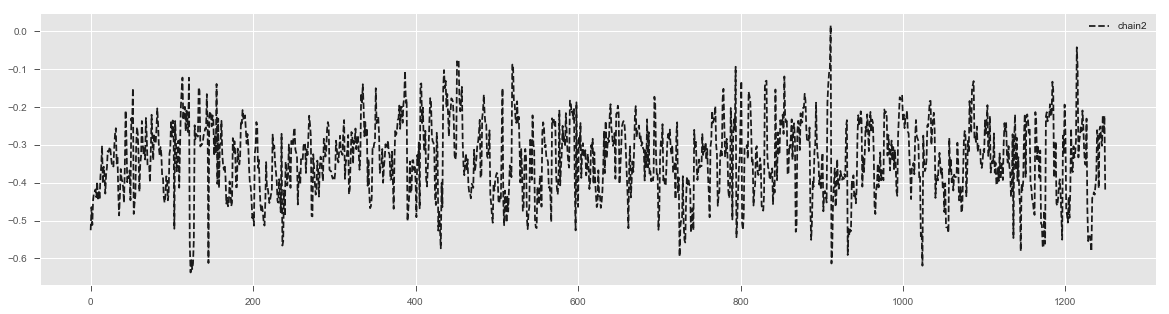

b1


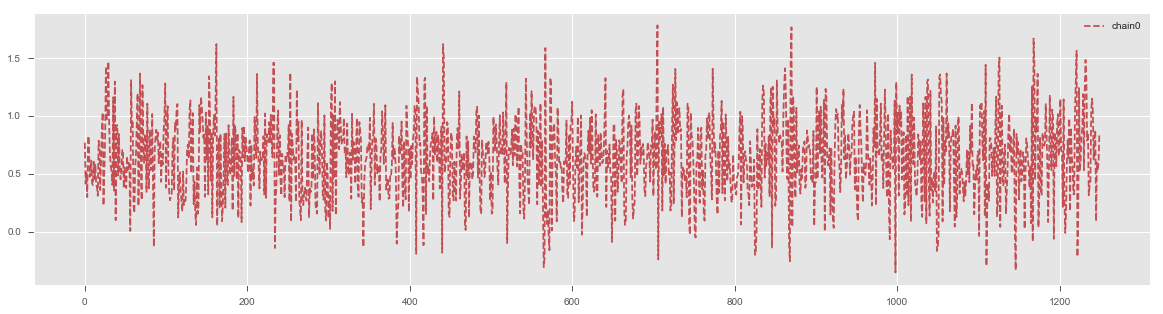

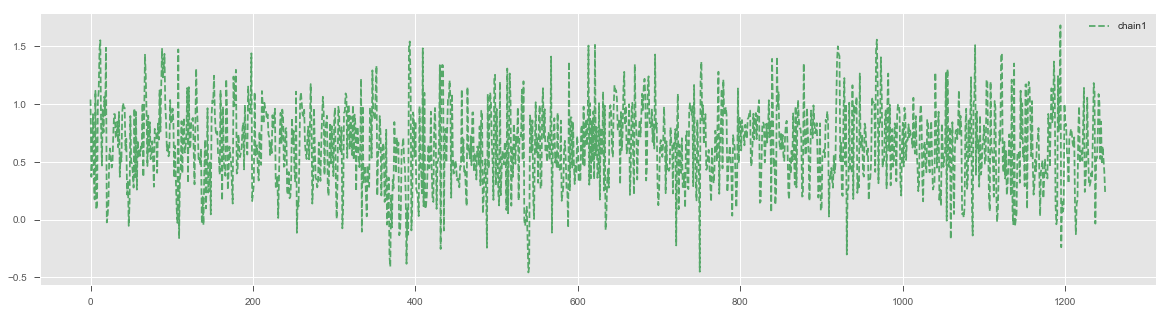

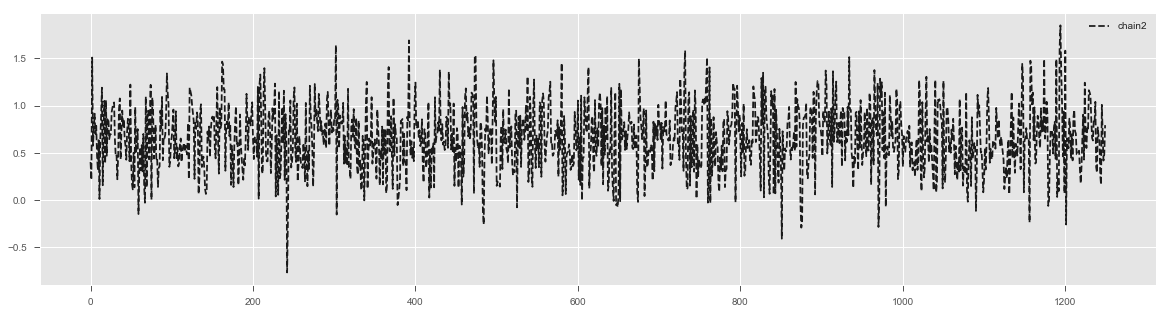

sig


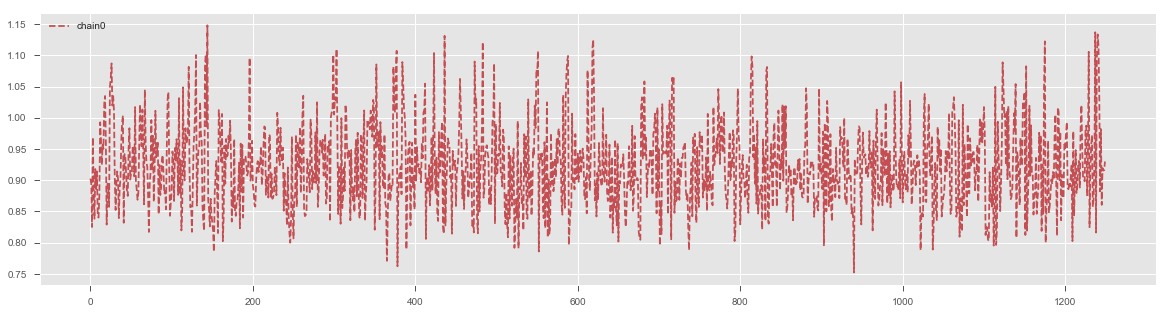

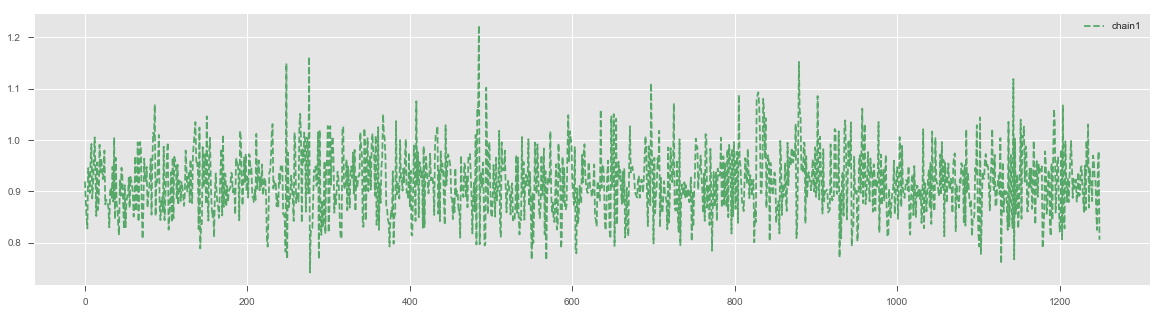

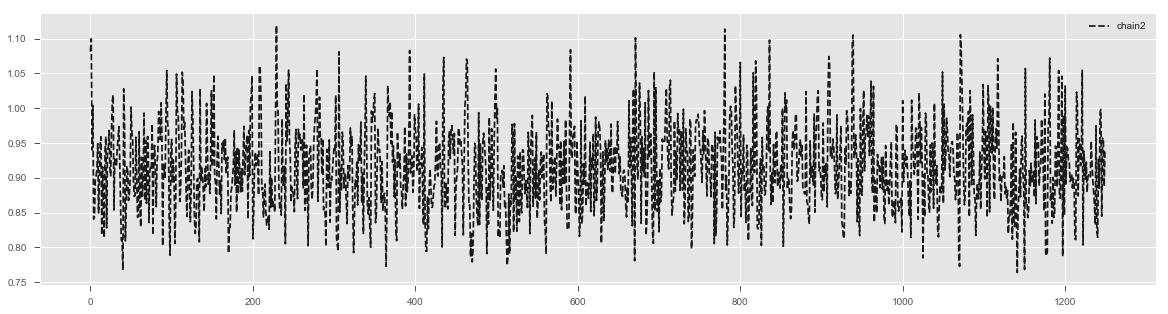

In [26]:
color = ['r--','g--','k--','b--']
for var in param:
    print(var)
    for i in range(0,nchain):
        plt.figure(figsize = (20,5))
        plt.style.use('ggplot')
        plt.plot(multi_trace1.get_values(var, chains=i)[3*niter//4:], color[i],label = 'chain'+str(i))
        plt.legend()
    plt.show()

## step 3: model checking -- Geweke -- difference of means, use of multiple chains

1. Let $H_0$ be the null hypothesis that there is **no difference** among means of the distributions from each of the stationary chains. That is: given $\theta_1$ and $\theta_2$ from chain 1 and chain 2
$$H_0 : \mu_{\theta_1}  - \mu_{\theta_2} = 0 \implies \mu_{\theta_1 - \theta_2} = 0$$
i.e. ** distribution of the difference in chain samples is a 0-mean distribution **

1. The standard deviation of this distribution is:
$$\sigma_{\theta_1 - \theta_2} = \sqrt{\frac{var(\theta_1)}{n_1} + \frac{var(\theta_2)}{n_2} }$$

1. hypothesis test: assume the usual rejection of $H_0$ if the p-value $<5\%$ : i.e. if $H_0$ is correct, there is only a 5% chance of the absolute value of the mean difference being larger than 2 std (1.96 to be precise). That is:

$$\vert \mu_{\theta_1}  - \mu_{\theta_2}  \vert > 2 \sigma_{\theta_1 - \theta_2} $$


a0


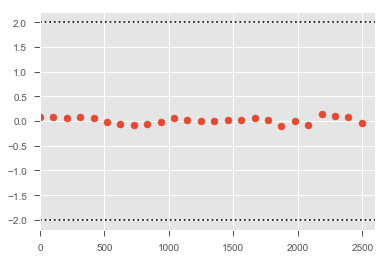

a1


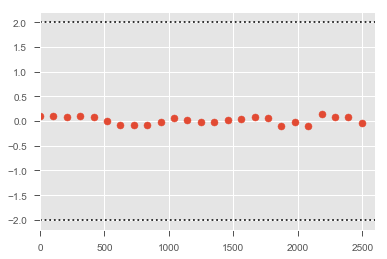

a2


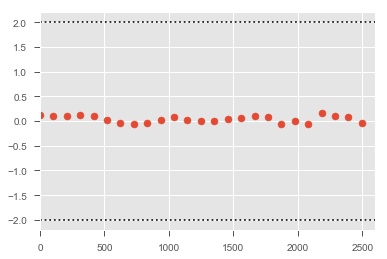

a3


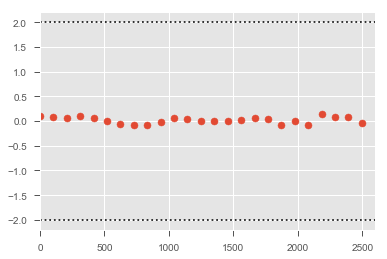

mua


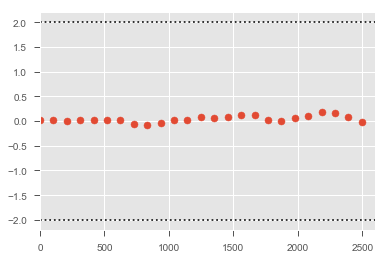

siga


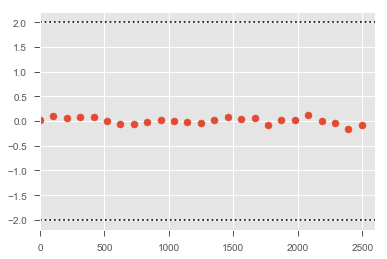

b0


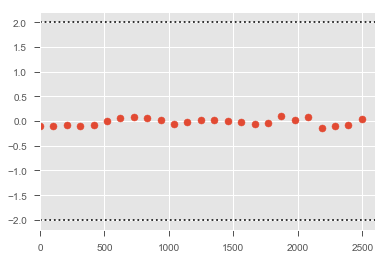

b1


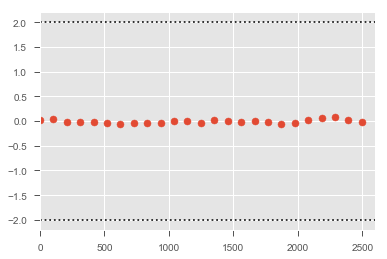

sig


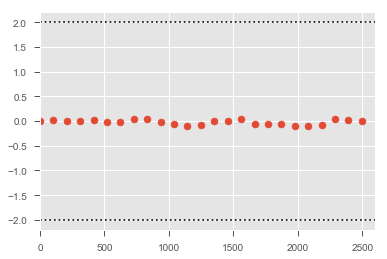

In [27]:

from pymc3 import geweke
z = geweke(trace, intervals=25)

for label in param:
    print(label)
    plt.scatter(*z[label].T)
    plt.hlines([-2,2], 0, z[label][-1][0]+100, linestyles='dotted')
    plt.xlim(0, z[label][-1][0]+100)
    plt.show()

## step 3: model checking-- gelman rubin & effective sample size check -- uses of multiple chains

It compares **between-chain** and **within-chain** variance. If these are very different we haven't converged yet.


Assume we have $m$ (3) chains, each of length $n$ (5000). The sample variance of the $C$-th chain is:
$$ s_C^2 =  \frac{1}{n-1} \sum_i (\theta_{iC} - \mu_{\theta_C})^2$$
Let $W$ be the mean of the within-chain variances. Then:

$$W= \frac{1}{m} \sum_C s_C^2$$


Let $\mu$ be the mean of the chain means:

$$\mu = \frac{1}{m} \sum_C \mu_{\theta_C}$$

The between chain variance can then be written as:

$$B = \frac{n}{m-1}\sum_C (\mu_{\theta_C} - \mu)^2$$

This is the variance of the chain means multiplied by the number of samples in each chain.

We use the weighted average of these two to estimate the variance of the stationary distribution:

$$\hat{Var}(\theta) = (1 - \frac{1}{n})W + \frac{1}{n} B$$

Note: the starting points of our chains are unlikely from the stationary distribution, this overestimates  variance. However, it is still unbiased under stationarity. So

$$\lim_{n \to \infty} \hat{Var}(\theta) = W$$

So, we can define an asymtotic value $\hat{R}$ as  ratio:
$$\hat{R} = \sqrt{\frac{\hat{Var}(\theta)}{W}}\approx 1\textit{ if stationary . Away from stationarity,  overestimation shows up in a ratio}  > 1$$

## effective sample size -- Autocorrelation -- Gelman only works when effective sample sizes are moderate

1. Large autocorr may happen when parameters are correlated (this needs to be checked before any modeling).
1. If step sizes are too small, then we cannot explore distribution well. In other words, our mixing is poor. 

Note autocorrelation by itself does not mean that our sampling is wrong. But it is something we should always investigate, and only use our samples if we are convinced that the autocorrelation is benign.

A good measure to have that depends on autocorrelation is effective sample size(ESS)--  measure how much "iid" is not true among our sample draws 'iid'ness of our draws decreases.
$$n_{eff} = \frac{mn}{1 + 2 \sum_{\Delta t}\rho_{\Delta t}},\textit{ where }\rho_{\Delta t} \textit{ is lag of }\Delta t $$

     gelman_rubin effective_n    lag1    lag5   lag10   lag15   lag50
a0        1.00045        3851  0.5396  0.0567  0.0138 -0.0106  0.0081
a1        1.00044        3870  0.5358  0.0596  0.0261  -0.012  0.0043
a2        1.00043        3908  0.5327  0.0589  0.0217 -0.0066  0.0049
a3        1.00033        3844  0.5379  0.0544  0.0185 -0.0124  0.0172
mua       1.00028        4369  0.4399  0.0581 -0.0088 -0.0142 -0.0049
siga     0.999984        3584  0.4599  0.0974  0.0071  0.0095  0.0048
b0        1.00042        3701  0.5711  0.0603  0.0194 -0.0072  0.0069
b1       0.999945        9627  0.1775 -0.0156   0.009   0.007  -0.011
sig       1.00006       10262  0.1485  0.0203  0.0073  0.0264  0.0021


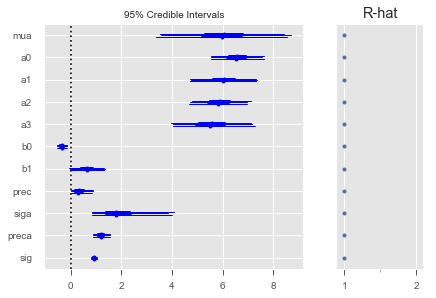


 DIC =  373.2684495884536


In [29]:


gelman_rubin = pm.diagnostics.gelman_rubin(multi_trace1)
effective_n  = pm.diagnostics.effective_n(multi_trace1)
lags         = [1,5,10,15,50]

gel_res = pd.DataFrame(index = param, columns = ['gelman_rubin','effective_n']+['lag'+ str(i) for i in lags])
for var in param:
    gel_res.loc[var] = [gelman_rubin[var],effective_n[var]]+[round(pm.stats.autocorr(trace,lag = l)[var],4) for l in lags]
print(gel_res)

from pymc3 import forestplot
forestplot(multi_trace1)
plt.show()

print('\n DIC = ',(pm.stats.dic(trace,model = linreg)))

In [26]:
#pm.stats.summary(trace)

In [31]:
# model checking__ predictions
coef = pd.Series(index = param)
for var in param:
    coef[var] = multi_trace1.get_values(var,burn = int(niter/2)).mean()
    
coef


a0      6.561366
a1      6.018300
a2      5.858505
a3      5.540064
mua     6.019626
siga    2.037797
b0     -0.342354
b1      0.640539
sig     0.918223
dtype: float64

##  test set 
## each location has 30 samples, so we create 30 X 5 y_hat : this is the mean of each location we have


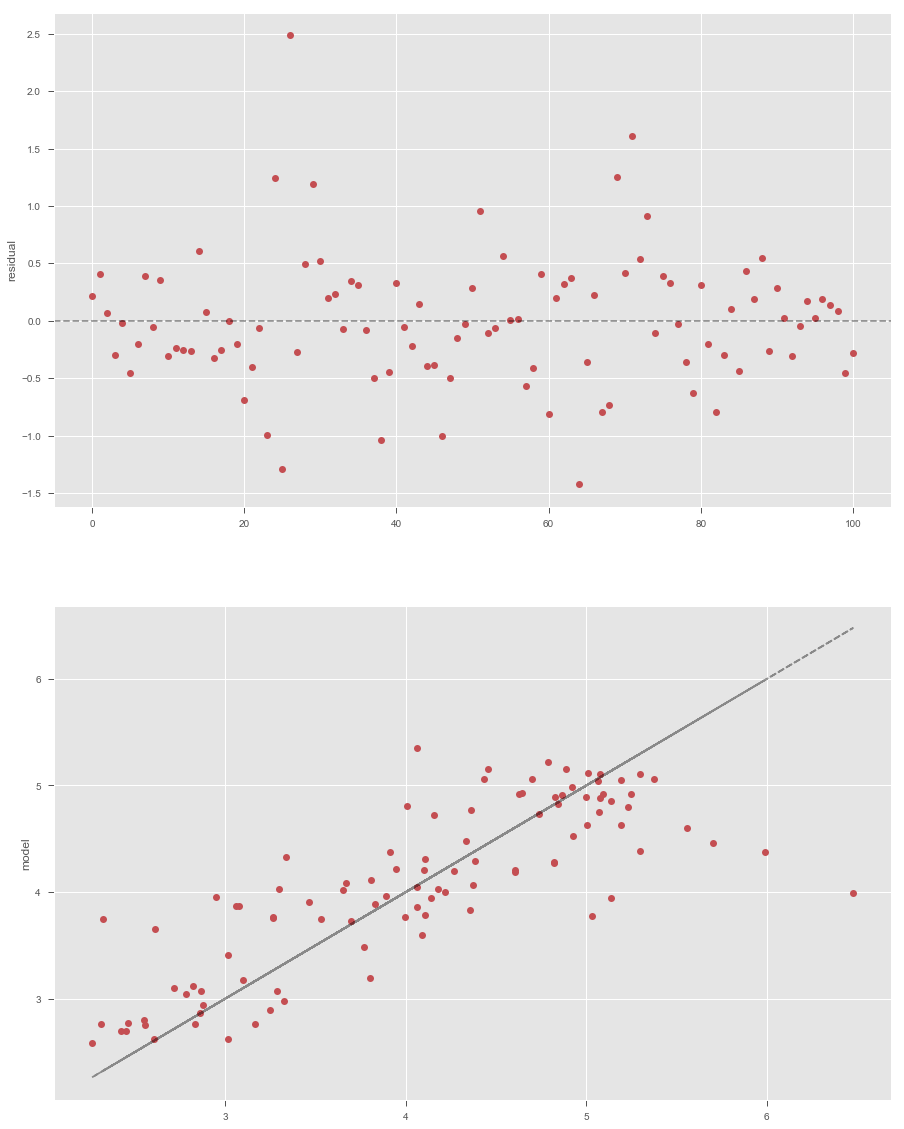

In [32]:
y_hat = np.zeros(y.shape)

for i in range(0,len(y)):
    y_hat[i] = (coef[param1[region[i]]] + coef['b0']*income[i]+coef['b1']*oil[i]) 
    
resid     = y-y_hat

fig, axes = plt.subplots(2, 1, figsize=(15,20))
axes = axes.ravel()
axes[0].plot(np.arange(len(resid)),resid,'ro')
axes[0].axhline(0,c='black', linestyle='dashed',alpha = 0.4)
axes[0].set_ylabel('residual')

axes[1].plot(y,y_hat,'ro')
axes[1].plot(y,y,'black',linestyle='dashed',alpha = 0.4)
axes[1].set_ylabel('model')

plt.show()

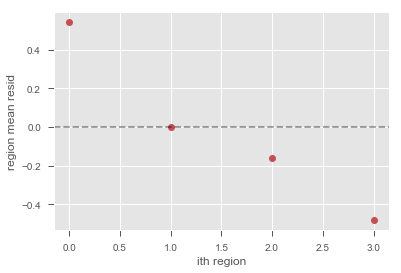

In [33]:
# each region ai, we predicted group mean mua, and compute the residual
resid_mean = coef[param1] - coef['mua']
plt.plot(np.arange(len(resid_mean)),resid_mean,'ro')
plt.axhline(0,c='black', linestyle='dashed',alpha = 0.4)
plt.xlabel('ith region')
plt.ylabel('region mean resid')
plt.show()